# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Признаки**  
`RowNumber` — индекс строки в данных  
`CustomerId` — уникальный идентификатор клиента  
`Surname` — фамилия  
`CreditScore` — кредитный рейтинг  
`Geography` — страна проживания  
`Gender` — пол  
`Age` — возраст  
`Tenure` — сколько лет человек является клиентом банка  
`Balance` — баланс на счёте  
`NumOfProducts` — количество продуктов банка, используемых клиентом  
`HasCrCard` — наличие кредитной карты  
`IsActiveMember` — активность клиента  
`EstimatedSalary` — предполагаемая зарплата   

**Целевой признак**  
`Exited` — факт ухода клиента

**Краткий план работы:**  
1. Подготовка данных
- Подготовка окружения
- Изучение данных
- Краткий исследовательский анализ данных  
  
2. Исследование задачи
- Предобработка данных
- Тестирование моделей  
  
3. Борьба с дисбалансом
- Random Forest Classifier
- Logistic Regression  
  
4. Тестирование модели

## Подготовка данных

### Подготовка окружения

In [1]:
!pip install -U scikit-learn
!pip install -U imbalanced-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score, make_scorer, precision_recall_curve, roc_curve

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 23.2 MB 130 kB/s ta 0:00:012
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 189 kB 2.3 MB/s eta 0:00:01


In [2]:
# Раскомментировать для включения широкоформатного Jupiter
# from IPython .core.display import display, HTML
# display(HTML("<style>.container {width:90% !important; }</style>"))

### Изучение данных

Сохраним данные в переменной `data`. Веведем на экран 5 строк.

In [3]:
data = pd.read_csv('/datasets/Churn.csv', index_col='RowNumber')

data.sample(5, random_state=23)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
6327,15788494,Alekseeva,555,France,Male,31,8.0,145875.74,1,1,0,137491.23,0
5186,15801169,Yegorova,764,Germany,Female,39,NaN,138341.51,1,1,0,50072.94,1
2496,15666548,Chung,466,Germany,Female,56,2.0,111920.13,3,1,0,197634.11,1
2766,15733876,Schneider,667,France,Male,36,9.0,0.00,2,1,1,40062.29,0
9304,15741403,Amechi,698,Spain,Female,38,1.0,171848.38,1,0,0,16957.45,0


Посмотрим описание и информацию о данных.

In [4]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


- Всего в данных 10000 строк
- В столбце `Tenure` имеются пропуски. (909 пропусков)

Не все признаки, представленные в данных будут нам полезны. Отберем признаки, которые могут нам пригодится в обучении модели.  
Для этого удалим из таблицы следующие признаки:
- CustomerId
- Surname

Сохраним новые данные в переменную `data_clear`

In [6]:
data_clear = data.drop(columns=['CustomerId', 'Surname'])

data_clear.sample(5, random_state=23)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
6327,555,France,Male,31,8.0,145875.74,1,1,0,137491.23,0
5186,764,Germany,Female,39,NaN,138341.51,1,1,0,50072.94,1
2496,466,Germany,Female,56,2.0,111920.13,3,1,0,197634.11,1
2766,667,France,Male,36,9.0,0.00,2,1,1,40062.29,0
9304,698,Spain,Female,38,1.0,171848.38,1,0,0,16957.45,0


### Краткий исследовательский анализ данных

Посмотрим на распределение данных.

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


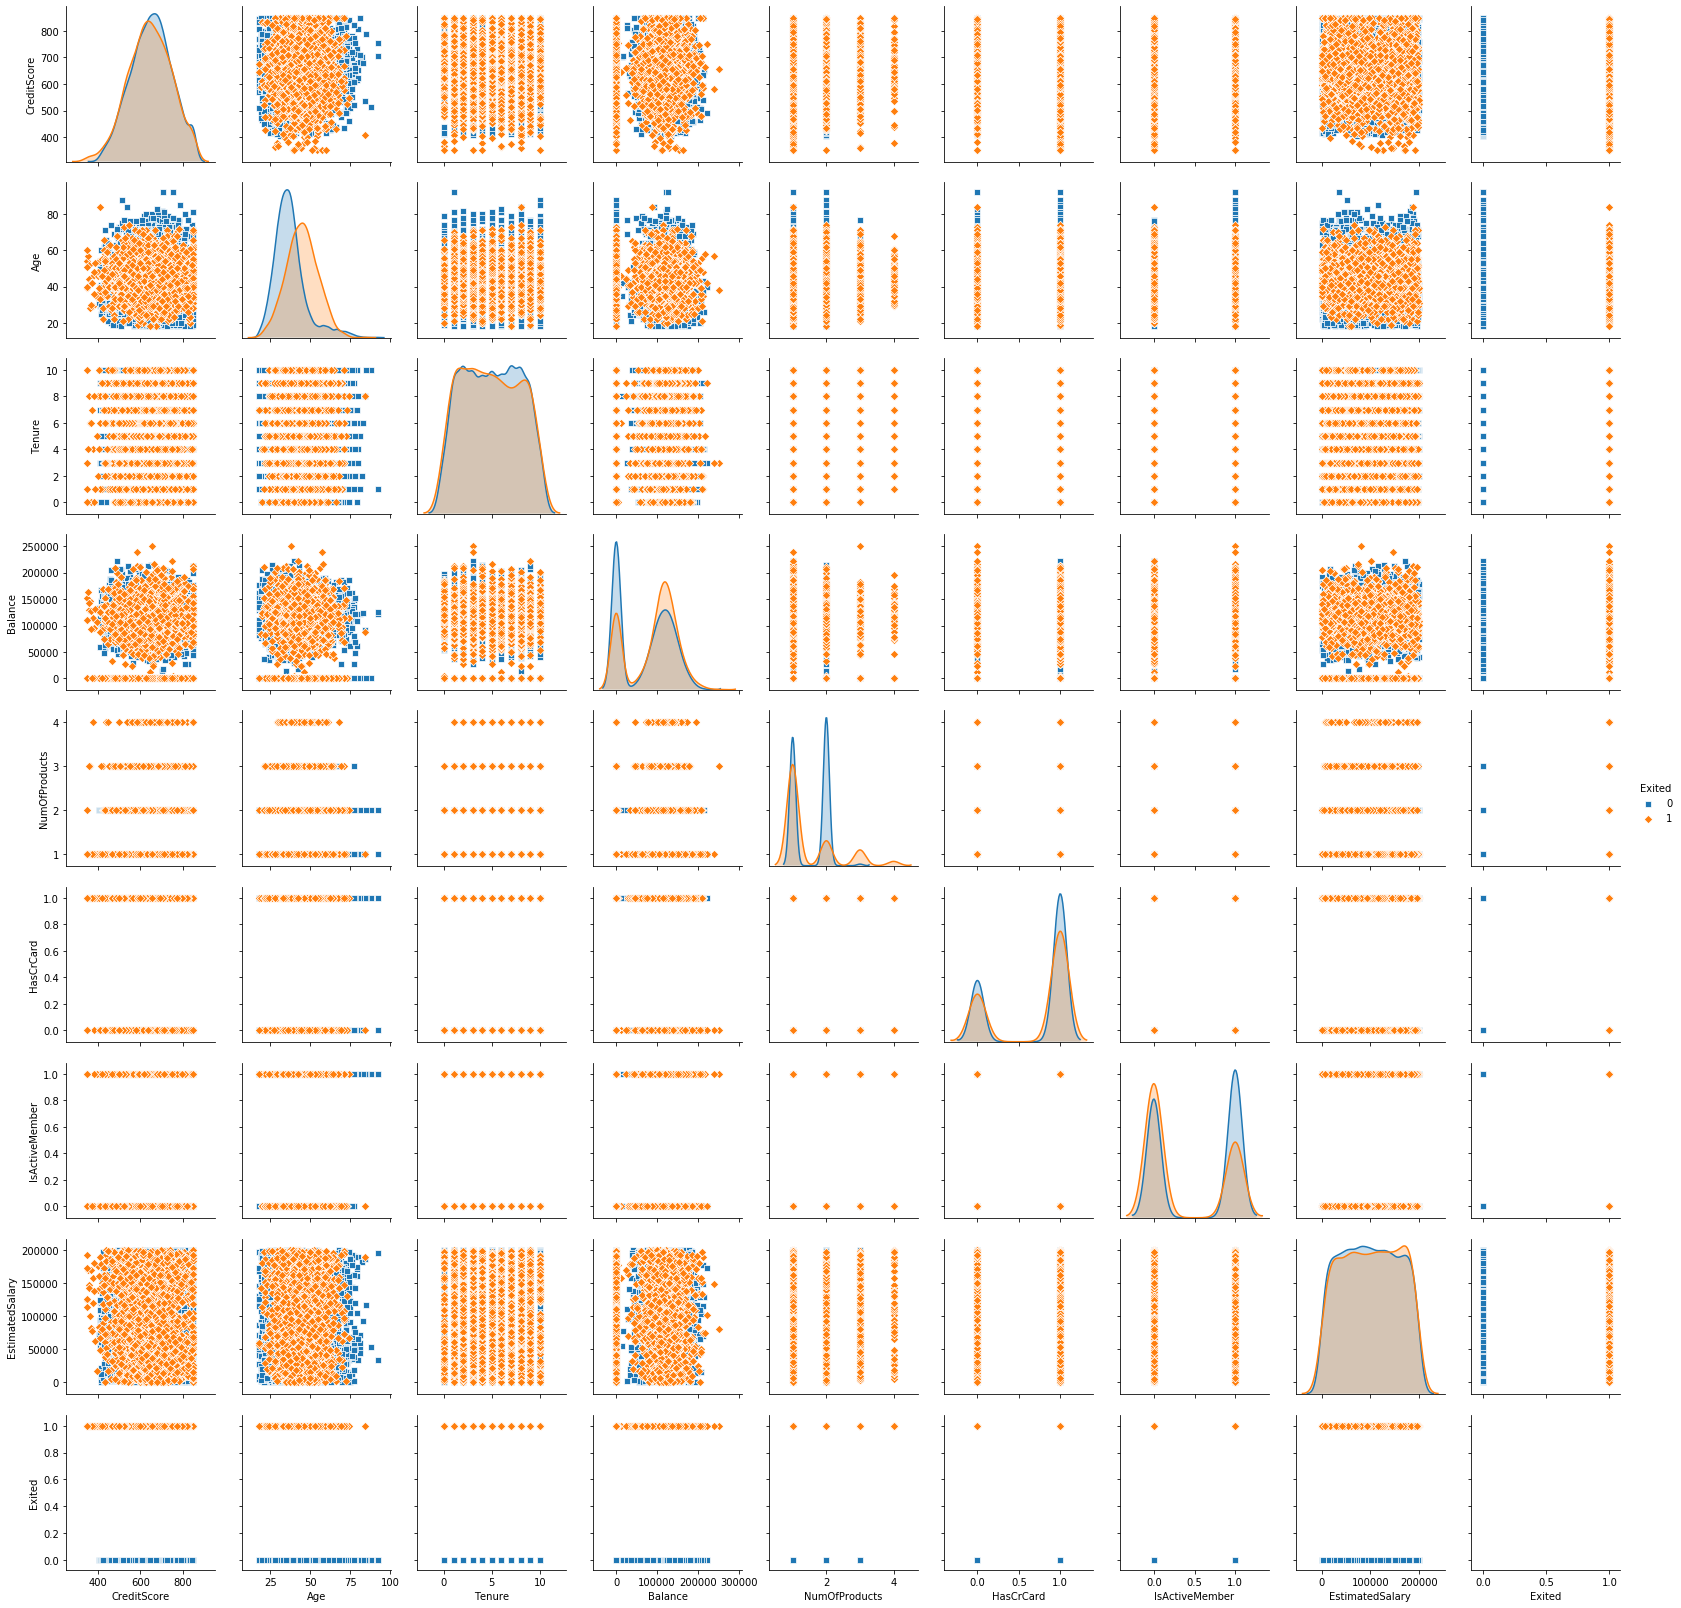

In [7]:
sns.pairplot(data=data_clear, hue='Exited', markers=["s", "D"]);

- Можно увидеть, что ушедшие от банка клиенты незначительно старше, нежели клиенты, которые остались.  
- Также видно, что большая доля ушедших клиентов обладала большим балансом, нежели клиенты, которые остались с банком.
- Больше всего ушедших клиентов банка находятся в категории людей, которые обладали всего лишь 1-м продуктом. При этом наибольшее количество людей, оставшихся с банком обладали 2-мя продуктами. 
- Среди активных клиентов количество ушедших клиентов меньше, чем тех, кто остался с банком.

Посмотрим есть ли явная зависимость целевой переменной от категориальных признаков `Gender` и `Geography`

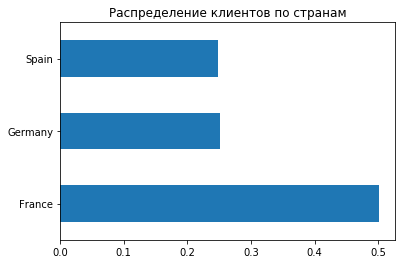

In [8]:
data_clear['Geography'].value_counts(normalize=True).plot.barh(title='Распределение клиентов по странам');

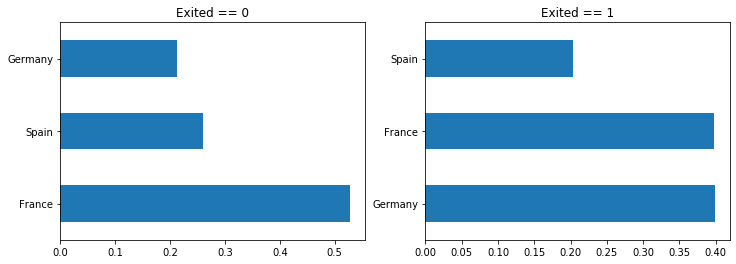

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

data_clear[data_clear['Exited'] == 0]['Geography'].value_counts(normalize=True).plot.barh(title='Exited == 0', ax=ax[0]);
data_clear[data_clear['Exited'] == 1]['Geography'].value_counts(normalize=True).plot.barh(title='Exited == 1', ax=ax[1]);

Большинство клиентов, которые ушли от банка находились в Германии (в Германии также наблюдается наименьшая доля лояльных клиентов) и Франции, при этом большая доля лояльных клиентов находится во Франции (стоит учесть, что во Франции в целом находится большее количество клиентов).

Посмотрим, как распределен целевой признак среди клиентов разного пола.

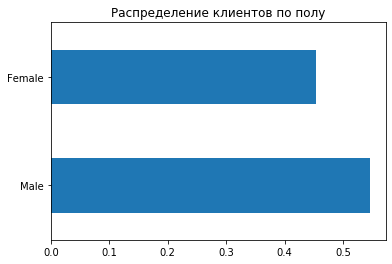

In [10]:
data_clear['Gender'].value_counts(normalize=True).plot.barh(title='Распределение клиентов по полу');

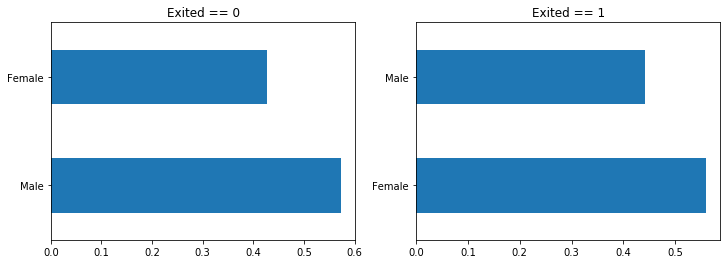

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

data_clear[data_clear['Exited'] == 0]['Gender'].value_counts(normalize=True).plot.barh(title='Exited == 0', ax=ax[0]);
data_clear[data_clear['Exited'] == 1]['Gender'].value_counts(normalize=True).plot.barh(title='Exited == 1', ax=ax[1]);

В целом в данных преобладают мужчины. Однако, среди клиентов, которые отказались от услуг банка доля женщин больше.

### Резюме

На основе краткого исследовательского анализа данных было выявлено:  
- Ушедшие клиенты незначительно старше, нежели клиенты, которые остались.  
- Большая доля ушедших клиентов обладала большим балансом на счете, нежели клиенты, которые остались с банком.
- Больше всего ушедших клиентов банка находятся в категории людей, которые обладали всего лишь 1-м продуктом. При этом наибольшее количество людей, оставшихся с банком обладали 2-мя продуктами. 
- Среди активных клиентов ушедших клиентов меньше.
- Большинство клиентов банка находятся во Франции, однако среди ушедших клиентов преобладают пользователи из Германии.
- Большинство клиентов банка мужчины, однако среди ушедших клиентов преобладают женщины. 
 
В качестве небольшого резюме, можно подвести итог: на первый взгляд похоже, что большинство клиентов, которые ушли из банка это люди более старшего возраста с бОльшим количеством денег на счетах, и пользующиеся преимущественно 1 продуктом.

## Исследование задачи

- Мы будем решать задачу бинарной классификации. Целевой признак - столбец `Exited`.   
- Метрика оценки качества - F1-мера. Дополнительно будем смотреть на метрику AUC-ROC
- В качестве моделей рассмотрим работу LogisticRegression и RandomForestClassifier

### Предобработка данных

Первым делом, нам необходимо обработать пропуски в столбце `Tenure`.  

In [12]:
print(f'Всего в столбце Tenure присутсвует {data_clear[data_clear.Tenure.isna()].shape[0]} пропусков')

Всего в столбце Tenure присутсвует 909 пропусков


Посмотрим на уникальные значения столбца Tenure

In [13]:
data_clear.Tenure.unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

В списке уникальных значений присутсвует значение "0". Значит, очень маловероятно, что пропуск означает 0 лет.

Посмотрим на строки, в которых в столбце Tenure содержится пропуск.

In [14]:
data_clear[data_clear.Tenure.isna()].sample(5, random_state=23)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
4312,727,Spain,Female,52,NaN,154733.97,1,1,0,80259.67,1
5470,723,France,Male,21,NaN,0.00,2,0,0,24847.02,0
8404,844,France,Female,28,NaN,0.00,2,0,1,123318.37,0
1673,513,France,Female,37,NaN,0.00,2,1,0,110142.34,0
8031,592,Spain,Male,38,NaN,0.00,1,1,1,12905.89,1


Посмотрим, как распределены значения в столбце Tenure.

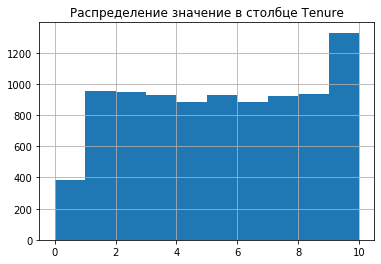

In [15]:
data_clear.Tenure.hist();
plt.title('Распределение значение в столбце Tenure');

Какой либо зависимости или явной причины, почему именно в данных строках присутствуют пропуски обнаружить не удалось.  

Для обучения логистической регрессии заполним пропуски нулями.  
Для обучения Случайного Леса заполним пропуски аномальным значением "-100"

Для начала преобразуем категориальные признаки методом One Hot Encoding

In [16]:
data_ohe = pd.get_dummies(data_clear, drop_first=True)
data_ohe.sample(5, random_state=23)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
6327,555,31,8.0,145875.74,1,1,0,137491.23,0,0,0,1
5186,764,39,NaN,138341.51,1,1,0,50072.94,1,1,0,0
2496,466,56,2.0,111920.13,3,1,0,197634.11,1,1,0,0
2766,667,36,9.0,0.00,2,1,1,40062.29,0,0,0,1
9304,698,38,1.0,171848.38,1,0,0,16957.45,0,0,1,0


Следующим шагом разделим выборку на признаки и целевую переменную.

In [17]:
X = data_ohe.drop('Exited', axis=1) # Признаки
y = data_ohe['Exited'] # Целевая переменная

Теперь заполним пропуски в матрице признаков для каждого алгоритма отдельно.

In [18]:
X_LR = X.fillna(0) # Признаки для обучения Логистической регрессии
X_RF = X.fillna(-100) # Признаки для обучения Случайного Леса

In [19]:
# Признаки для обучения Логистической регрессии (делим на train(80%) и test(20%))
X_LR_train_80, X_LR_test, y_LR_train_80, y_LR_test = train_test_split(X_LR, y, test_size=0.2, random_state=23, stratify=y)
print('Признаки для обучения Логистической регрессии')
print(X_LR_train_80.shape, X_LR_test.shape)
print(y_LR_train_80.shape, y_LR_test.shape)

# Признаки для обучения Случайного Леса (делим на train(80%) и test(20%))
X_RF_train_80, X_RF_test, y_RF_train_80, y_RF_test = train_test_split(X_RF, y, test_size=0.2, random_state=23, stratify=y)
print('Признаки для обучения Случайного Леса')
print(X_RF_train_80.shape, X_RF_test.shape)
print(y_RF_train_80.shape, y_RF_test.shape)

Признаки для обучения Логистической регрессии
(8000, 11) (2000, 11)
(8000,) (2000,)
Признаки для обучения Случайного Леса
(8000, 11) (2000, 11)
(8000,) (2000,)


Также, отделим валидационную выборку. 60 - означает, что данный тренировочный набор признаков содержит 60% данных.

In [20]:
# Признаки для обучения Логистической регрессии
X_LR_train_60, X_LR_val, y_LR_train_60, y_LR_val = train_test_split(X_LR_train_80, y_LR_train_80, test_size=0.25, random_state=23, stratify=y_LR_train_80)
print('Признаки для обучения Логистической регрессии')
print(X_LR_train_60.shape, X_LR_val.shape)
print(y_LR_train_60.shape, y_LR_val.shape)

# Признаки для обучения Случайного Леса
X_RF_train_60, X_RF_val, y_RF_train_60, y_RF_val = train_test_split(X_RF_train_80, y_RF_train_80, test_size=0.25, random_state=23, stratify=y_RF_train_80)
print('Признаки для обучения Случайного Леса')
print(X_RF_train_60.shape, X_RF_val.shape)
print(y_RF_train_60.shape, y_RF_val.shape)

Признаки для обучения Логистической регрессии
(6000, 11) (2000, 11)
(6000,) (2000,)
Признаки для обучения Случайного Леса
(6000, 11) (2000, 11)
(6000,) (2000,)


### Тестирование моделей

Посмотрим, какая из моделей покажет наибольший f1_score и roc_auc_score на кросс-валидации. 

In [21]:
results_table = pd.DataFrame() # Создадим таблицу, в которую сохраним результат работы моделей

scoring = {'ROC-AUC': make_scorer(roc_auc_score), # Зададим необходимые нам метрики
           'f1_score': make_scorer(f1_score)}

for name, model in {'RF': RandomForestClassifier,
                    'LR': LogisticRegression, 
                    'Dummy': DummyClassifier}.items():
    if name == 'RF':
        results = cross_validate(estimator=model(random_state=23),
                                  X=X_RF_train_80,
                                  y=y_RF_train_80,
                                  scoring=scoring)
    elif name == 'Dummy':
        results = cross_validate(estimator=model(strategy='uniform', random_state=23),
                                 X=X_LR_train_80,
                                 y=y_LR_train_80,
                                 scoring=scoring)
        
    else:
        results = cross_validate(estimator=model(random_state=23),
                                 X=X_LR_train_80,
                                 y=y_LR_train_80,
                                 scoring=scoring)
        
    val = {n: np.mean(v) for n, v in results.items()} # Создаем словарь, в котором значениями будут выступать средний результат кросс-валидации
    results_table[name] = val.values()                # Добавляем средний результат модели на кросс-валидации в таблицу

results_table.index = results     # Зададим индексы таблицы результатов
results_table = results_table[2:] # Оставим только нужные нам метрики

In [22]:
# Выведем таблицу на экран
results_table

,RF,LR,Dummy
test_ROC-AUC,0.708904,0.517125,0.49191
test_f1_score,0.566837,0.089303,0.28206


**Краткое резюме**

Наилучший результат на кросс-валидации показал алгоритм Случайный Лес.  
Следующим шагом, поработаем с дисбалансом классов в признаках, а также подберем гиперпараметры для моделей.

## Борьба с дисбалансом

Посмотрим, как распределены классы.

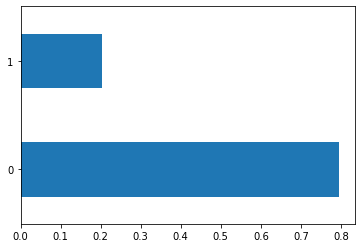

In [23]:
data_clear['Exited'].value_counts(normalize=True).plot.barh();

In [24]:
Counter(y_RF_train_80)

Counter({0: 6370, 1: 1630})

В данных присутсвует явный дисбаланс классов. 
- Первым шагом, уберем дисбаланс классов и проверим, насколько изменится результат дефолтной модели на сбалансированной выборке
- Следующим шагом подберем наилучшие гиперпараметры модели, используя наилучшую выборку.

In [25]:
1630/(1630+6370)

0.20375

### Random Forest Classifier

Преобразуем выборку, используя 4 варианта борьбы с дисбалансом:
- Гиперпараметр class_weight='balanced'
- Upsampling
- Downsampling
- Combined Random Sampling

Будем работать с выборкой 60%, чтобы на валидационной выборке проверять результат обучения.

Вначале используем OverSampling к нашей тренировочной выборке

In [26]:
ros = RandomOverSampler(random_state=23)
X_RF_train_ros, y_RF_train_ros = ros.fit_resample(X_RF_train_60, y_RF_train_60)

Counter(y_RF_train_ros)

Counter({0: 4778, 1: 4778})

Теперь применим UnderSampling к нашей выборке

In [27]:
rus = RandomUnderSampler(random_state=23)
X_RF_train_rus, y_RF_train_rus = rus.fit_resample(X_RF_train_60, y_RF_train_60)

Counter(y_RF_train_rus)

Counter({0: 1222, 1: 1222})

И в заключении применим последовательно оба метода к нашей выборке.

In [28]:
# Инициализируем over / under sampler
over = RandomOverSampler(sampling_strategy=0.5, random_state=23)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=23)

# Используем OverSampling к наименьшему классу
X_over, y_over = over.fit_resample(X_RF_train_60, y_RF_train_60)

print(f"Oversampled: {Counter(y_over)}")

# Теперь испульзуем UnderSampling к наибольшему классу
X_RF_train_combined_sampling, y_RF_train_combined_sampling = under.fit_resample(X_over, y_over)

print(f"Combined Random Sampling: {Counter(y_RF_train_combined_sampling)}")

Oversampled: Counter({0: 4778, 1: 2389})
Combined Random Sampling: Counter({0: 2986, 1: 2389})


Обучим модель RandomForest на всех трех выборках, а также используем гиперпараметр class_weight='balanced' и проверим, в каком случае дефолтная модель Случайного Леса покажет лучший результат.

In [29]:
results_sampling_table = pd.DataFrame() # Создадим таблицу, в которую сохраним результат работы моделей

for name, features in {'ROS': [X_RF_train_ros, y_RF_train_ros],
                       'RUS': [X_RF_train_rus, y_RF_train_rus], 
                       'COMBO': [X_RF_train_combined_sampling, y_RF_train_combined_sampling], 
                       'Class-Weight': [X_RF_train_60, y_RF_train_60]}.items():
    
    if name == 'Class-Weight':
        model = RandomForestClassifier(random_state=23, class_weight='balanced')
    else:
        model = RandomForestClassifier(random_state=23)
    
    model.fit(features[0], features[1])
    pred = model.predict(X_RF_val)
    
    f1 = f1_score(y_RF_val, pred)
    roc_auc = roc_auc_score(y_RF_val, pred)
    
    results_sampling_table[name] = [f1, roc_auc]     

# Зададим индексы таблицы результатов
results_sampling_table.index = ['f1_score', 'ROC-AUC'] 

In [30]:
# Выведем таблицу на экран
results_sampling_table

,ROS,RUS,COMBO,Class-Weight
f1_score,0.596100,0.588346,0.606742,0.551938
ROC-AUC,0.732104,0.775852,0.750684,0.699607


Наилучший результат F1_score на валидационной выборке показала модель, обученная на Comined Sampling признаках.  
Наилучший результат ROC_AUC на валидационной выборке показала модель, обученная на Under Sampling признаках.  

Следующим шагом оптимизируем гиперпараметры для модели, которая будет обучена на Combined Random Sampling признаках.

In [31]:
# Словарь значений гиперпараметров, которые будем перебирать
params = {'n_estimators': [100, 200, 300],
          'max_depth': [None, 7, 10, 13, 15], 
          'min_samples_split': [2, 3, 4], 
          'min_samples_leaf': [1, 2, 3],  
          'class_weight': ['balanced', None]}

In [32]:
model_best_RF = None
best_params = {'n_estimators': None,
               'max_depth': None, 
               'min_samples_split': None, 
               'min_samples_leaf': None,  
               'class_weight': None}
f1_best = 0
roc_auc_final = None

# Осуществим перебор гиперпараметров в цикле
for n_estimator in tqdm(params['n_estimators'], desc="Идет перебор гиперпараметров...", colour='green'):
    for max_depth in tqdm(params['max_depth']):
        for min_samples_split in params['min_samples_split']:
            for min_samples_leaf in params['min_samples_leaf']:
                for class_weight in params['class_weight']:
                    # Инициализируем модель
                    model = RandomForestClassifier(random_state=23, 
                                                   n_estimators=n_estimator, 
                                                   max_depth=max_depth, 
                                                   min_samples_split=min_samples_split, 
                                                   min_samples_leaf=min_samples_leaf, 
                                                   class_weight=class_weight)
                    
                    # Обучаем модель на Combined (Over + Under)Sampling признаках
                    model.fit(X_RF_train_combined_sampling, y_RF_train_combined_sampling)
                    
                    # Делаем предсказание для валидационной выборки
                    pred = model.predict(X_RF_val)
                    
                    # Находим значение метрик
                    f1 = f1_score(y_RF_val, pred)
                    roc_auc = roc_auc_score(y_RF_val, pred)
                    
                    # Лучшие параметры добавляем в переменные
                    if f1 > f1_best:
                        model_best_RF = model
                        f1_best = f1
                        roc_auc_final = roc_auc
                        best_params['n_estimators'] = n_estimator
                        best_params['max_depth'] = max_depth
                        best_params['min_samples_split'] = min_samples_split
                        best_params['min_samples_leaf'] = min_samples_leaf
                        best_params['class_weight'] = class_weight

Идет перебор гиперпараметров...: 100%|██████████| 3/3 [07:35<00:00, 151.81s/it]


In [33]:
print('f1_best:', f1_best)
print('roc_auc_final:', roc_auc_final)
display(best_params)

f1_best: 0.6279863481228668
roc_auc_final: 0.7769915755246822


{'n_estimators': 100,
 'max_depth': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'class_weight': None}

### Logistic Regression

Преобразуем выборку, используя 4 варианта борьбы с дисбалансом:
- Гиперпараметр class_weight='balanced'
- Upsampling
- Downsampling
- Combined Random Sampling  
 
А также попробуем подобрать порог, для увеличения точности предсказания.

Также, как и в случае со случайным лесом, будем работать с выборкой 60%, чтобы на валидационной выборке проверять результат обучения.

Вначале используем OverSampling к нашей тренировочной выборке

In [34]:
ros = RandomOverSampler(random_state=23)
X_LR_train_ros, y_LR_train_ros = ros.fit_resample(X_LR_train_60, y_LR_train_60)

Counter(y_LR_train_ros)

Counter({0: 4778, 1: 4778})

Теперь применим UnderSampling к нашей выборке

In [35]:
rus = RandomUnderSampler(random_state=23)
X_LR_train_rus, y_LR_train_rus = rus.fit_resample(X_LR_train_60, y_LR_train_60)

Counter(y_LR_train_rus)

Counter({0: 1222, 1: 1222})

И в заключении применим последовательно оба метода к нашей выборке.

In [36]:
# Инициализируем over / under sampler
over = RandomOverSampler(sampling_strategy=0.5, random_state=23)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=23)

# Используем OverSampling к наименьшему классу
X_over, y_over = over.fit_resample(X_LR_train_60, y_LR_train_60)

print(f"Oversampled: {Counter(y_over)}")

# Теперь испульзуем UnderSampling к наибольшему классу
X_LR_train_combined_sampling, y_LR_train_combined_sampling = under.fit_resample(X_over, y_over)

print(f"Combined Random Sampling: {Counter(y_LR_train_combined_sampling)}")

Oversampled: Counter({0: 4778, 1: 2389})
Combined Random Sampling: Counter({0: 2986, 1: 2389})


Обучим модель LogisticRegression на всех трех выборках, а также используем гиперпараметр class_weight='balanced' и проверим, в каком случае дефолтная модель Логистической Регрессии покажет лучший результат.

In [37]:
results_sampling_table_LR = pd.DataFrame() # Создадим таблицу, в которую сохраним результат работы моделей

for name, features in {'ROS': [X_LR_train_ros, y_LR_train_ros],
                       'RUS': [X_LR_train_rus, y_LR_train_rus], 
                       'COMBO': [X_LR_train_combined_sampling, y_LR_train_combined_sampling], 
                       'Class-Weight': [X_LR_train_60, y_LR_train_60]}.items():
    
    if name == 'Class-Weight':
        model = LogisticRegression(random_state=23, class_weight='balanced', solver='liblinear')
    else:
        model = LogisticRegression(random_state=23, solver='liblinear')
    
    model.fit(features[0], features[1])
    pred = model.predict(X_LR_val)
    
    f1 = f1_score(y_LR_val, pred)
    roc_auc = roc_auc_score(y_LR_val, pred)
    
    results_sampling_table_LR[name] = [f1, roc_auc]                        
                            
results_sampling_table_LR.index = ['f1_score', 'ROC-AUC']     # Зададим индексы таблицы результатов

In [38]:
# Выведем таблицу с результатами на экран
results_sampling_table_LR

,ROS,RUS,COMBO,Class-Weight
f1_score,0.440920,0.434445,0.436911,0.434851
ROC-AUC,0.660096,0.654381,0.651776,0.654473


F1_score практически одинаковый у всех моделей. У модели, обученной на OverSampling выборке, значение незначительно выше и составляет 44%.

Обучим модель на OverSampling выборке и попробуем подобрать подходящие гиперпараметры, чтобы повысить значение f1 метрики.

In [39]:
# Словарь значений гиперпараметров, которые будем перебирать
params_LR = {'penalty': ['l1', 'l2'], 
             'C': [0.2, 0.5, 0.7, 1],
             'intercept_scaling': [1, 2, 3],
             'class_weight': ['balanced', None]}

In [40]:
model_best_LR = None
best_params_LR = {'penalty': None, 
                  'C': None,
                  'intercept_scaling': None,
                  'class_weight': None}
f1_best_LR = 0
roc_auc_final_LR = None

# Осуществим перебор гиперпараметров в цикле
for penalty in tqdm(params_LR['penalty'], desc="Идет перебор гиперпараметров...", colour='green'):
    for C in tqdm(params_LR['C']):
        for intercept_scaling in params_LR['intercept_scaling']:
            for class_weight in params_LR['class_weight']:
                # Инициализируем модель
                model = LogisticRegression(solver='liblinear', 
                                           random_state=23, 
                                           penalty=penalty, 
                                           C=C, 
                                           intercept_scaling=intercept_scaling,  
                                           class_weight=class_weight)

                # Обучаем модель на Over Sampling признаках
                model.fit(X_LR_train_ros, y_LR_train_ros)

                # Делаем предсказание для валидационной выборки
                pred = model.predict(X_LR_val)

                # Находим значение метрик
                f1 = f1_score(y_LR_val, pred)
                roc_auc = roc_auc_score(y_LR_val, pred)

                # Лучшие параметры добавляем в переменные
                if f1 > f1_best_LR:
                    model_best_LR = model
                    f1_best_LR = f1
                    roc_auc_final_LR = roc_auc
                    best_params_LR['penalty'] = penalty
                    best_params_LR['C'] = C
                    best_params_LR['intercept_scaling'] = intercept_scaling
                    best_params_LR['class_weight'] = class_weight

Идет перебор гиперпараметров...: 100%|██████████| 2/2 [00:11<00:00,  5.99s/it]


In [41]:
print('f1_score', f1_best_LR)
print('ROC_AUC', roc_auc_final_LR)
display(best_params_LR)

f1_score 0.49955555555555564
ROC_AUC 0.707428071731205


{'penalty': 'l1', 'C': 1, 'intercept_scaling': 3, 'class_weight': 'balanced'}

Путем подбора гиперпараметров, нам удалось повысить значение f1-метрики с 44% до 49,9%

Посмотрим, получится ли нам улучшить этот показатель путем перебора порога.

In [42]:
threshold_best = 0
f1_val_best = 0
roc_auc_for_best_thresh = 0

for threshold in np.arange(0, 0.99, 0.01):
    probability_val = model_best_LR.predict_proba(X_LR_val)[:, 1]
    prediction_val = probability_val > threshold
    f1_val = f1_score(y_LR_val, prediction_val)
    roc_auc_for_thresh = roc_auc_score(y_LR_val, prediction_val)
    if f1_val > f1_val_best:
        f1_val_best = f1_val
        threshold_best = threshold
        roc_auc_for_best_thresh = roc_auc_for_thresh
        
print(f'threshold_best: {threshold_best} | f1_score: {f1_val_best} | ROC-AUC {roc_auc_for_best_thresh}')

threshold_best: 0.56 | f1_score: 0.5045778229908443 | ROC-AUC 0.7012205636023254


При пороге в 0.56 f1-метрика модели доходит до 50,5%, что незначительно выше показателя 49,9%, который мы получили после подбора гиперпараметров.

### Резюме

На данном этапе мы проверили результативность двух моделей:
- Случайный Лес
- Логистическая Регрессия  
 
Каждую модель мы обучили на 3-х выборках:
- Oversampling выборке
- Undersampling выборке
- Combined Random Sampling выборке  
А также использовали настройку гиперпараметра class_weight='balanced' для обучения на стантдартной выборке.  
 
Случайный лес показал наилучший результат (f1_score=60,6%) на Combined Random Sampling выборке, в то время как Логистическая регрессия показала наилучший результат (f1_score=44%) на Oversampling выборке.  
 
Следующим шагом для каждой из моделей была взята выборка, на которой она показала наилучший результат, и был произведен процесс оптимизации настроек гиперпараметров. После оптимизации были получены следующие результаты на валидационной выборке:  

|    | LR | RF |
| -------- | ------ | ----- |
| f1_score | 0.4996 | 0.628 |
| ROC_AUC  | 0.707  | 0.777 |

## Тестирование модели

Пришло время проверить обе модели на тестовой выборке.

In [43]:
print('RF - f1_score:', f1_score(y_RF_test, model_best_RF.predict(X_RF_test)))
print('RF - ROC_AUC:', roc_auc_score(y_RF_test, model_best_RF.predict(X_RF_test)))

print('----------------------------------')

print('LR - f1_score:', f1_score(y_LR_test, model_best_LR.predict(X_LR_test)))
print('LR - ROC_AUC:', roc_auc_score(y_LR_test, model_best_LR.predict(X_LR_test)))

RF - f1_score: 0.6209302325581395
RF - ROC_AUC: 0.7696294136972103
----------------------------------
LR - f1_score: 0.47241379310344833
LR - ROC_AUC: 0.6862640760945845


Модель Случайного Леса показала наилучший результат на тестовой выборке: f1_score = 62%

Посмотрим на важность признаков.

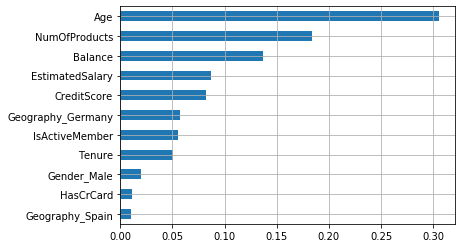

In [44]:
feat_imp = pd.Series(model_best_RF.feature_importances_, index=X_RF_train_combined_sampling.columns)

feat_imp.sort_values().plot.barh(grid=True);

Можно сделать вывод, что наибольшее влияние на факт ухода клиента имеет возраст и количество продуктов у пользователя.

Также, можно вглянуть на кривую Precision-Recall и ROC-кривую

In [45]:
# Зададим функцию, которая построит график Precision-Recall
def precision_recall_plot(title=None, model=None, X=None, y=None, ax=None):
    probabilities_valid = model.predict_proba(X)
    precision, recall, thresholds = precision_recall_curve(y, probabilities_valid[:, 1])

    ax.step(recall, precision, where='post')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    
# Зададим функцию, которая построит график ROC_AUC
def roc_curve_plot(title='ROC-кривая', model=None, X=None, y=None, ax=None):
    probabilities_valid = model.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probabilities_valid[:, 1]) 
    
    ax.step(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_ylim([0.0, 1.0])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)

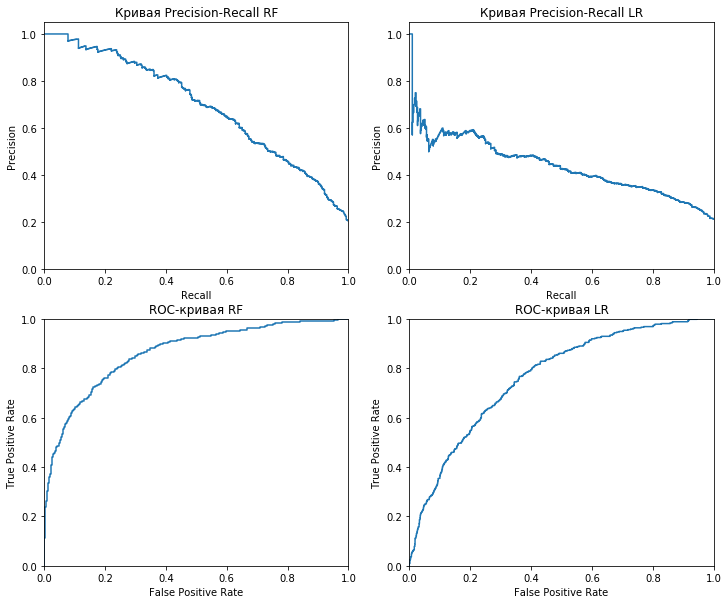

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

precision_recall_plot(title='Кривая Precision-Recall RF', model=model_best_RF, X=X_RF_test, y=y_RF_test, ax=ax1);
precision_recall_plot(title='Кривая Precision-Recall LR', model=model_best_LR, X=X_LR_test, y=y_LR_test, ax=ax2);

roc_curve_plot(title='ROC-кривая RF', model=model_best_RF, X=X_RF_test, y=y_RF_test, ax=ax3);
roc_curve_plot(title='ROC-кривая LR', model=model_best_LR, X=X_LR_test, y=y_LR_test, ax=ax4);

## Вывод

В ходе работы были произведены следующие шаги:
1. **Был проведен краткий исследовательский анализ данных**
2. **Была осуществлена предобработка данных и подготовка признаков. В ходе предобработки данных, мы:**
- Избавились от признаков, которые не несут никакой информативности для модели. 
- Для каждой из моделей заполнили пропуски определенным образом.
- Преобразовали категориальные признаки методом One Hot Encoding
- Разделили выборку на тренировочную-80%, тренировочную-60%, валидационную и тестовую.
 
3. **Была исследована работа моделей с настройками по умолчанию на имеющейся выборке.** Средние результаты работы моделей, проверенные на кросс-валидации (выборка train-80%) выглядят следующим образом:  
| | RF | LR | Dummy |
| -------- | ------- | -------- | -------- |
|f1_score|	**0.567** |	0.089|	0.282
|ROC-AUC|	**0.709** |	0.517|	0.491


Наилучший f1_score показала модель Случайного Леса.

4. **Была произведена борьба с дисбалансом классов.** Для каждой модели были использованы 4 способа борьбы с дисбалансом:
- Upsampling
- Downsampling
- Combined Random Sampling
- Настройка гиперпараметра class_weight='balanced'
 
Случайный лес показал наилучший результат (f1_score=60,6%) на Combined Random Sampling выборке, в то время как Логистическая регрессия показала наилучший результат (f1_score=44%) на Oversampling выборке.  
  
5. **Был осуществлен подбор гиперпараметров для моделей, которые обучались на трансформированных с учетом дисбаланса классов выборках.** Результаты моделей на валидационной выборке с оптимизированными гиперпараметрами выглядят следующим образом:  

|    |  RF | LR |
| -------- | ------ | ----- |
| f1_score | **0.628** | 0.4996 |
| ROC_AUC  |  **0.777** | 0.707  |

6. **Финальное тестирование моделей.**  
 
В заключении, на тестовой выборке были получены следующие результаты:

|   | Случайный Лес | Логистическая Регрессия|
| -------- | ------- | -------- |
| f1_score| **0.62** | 0.47 |
| ROC_AUC | **0.7696** | 0.686 |

Наилучший перформанс показала модель Случайного Леса, обученная на Combined Random Sampling выборке, со следующими гиперпараметрами:    

| Гиперпараметры модели| Значение гиперпараметра |
| ----------- | -------- |
| 'n_estimators' | 100 |
| 'max_depth' | 10 |
| 'min_samples_split' | 2 |
| 'min_samples_leaf' | 2 |
| 'class_weight' | None |
 
7. **В зкалючении, был исследован вклад признаков в предсказания модели.** График важности признаков выглядит следующим образом:  

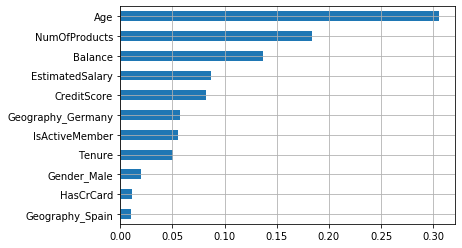  

Таким образом, хорошо видно, что факт ухода клиента больше всего зависит от его возраста и количества используемых продуктов.


## Полезные статьи

[How to compute precision,recall and f1 score of an imbalanced dataset for K fold cross validation?](https://stackoverflow.com/questions/46598301/how-to-compute-precision-recall-and-f1-score-of-an-imbalanced-dataset-for-k-fold)  
[ray-project/tune-sklearn - A drop-in replacement for Scikit-Learn’s GridSearchCV / RandomizedSearchCV -- but with cutting edge hyperparameter tuning techniques](https://github.com/ray-project/tune-sklearn)  
[Как победить несбалансированность датасета: метод upsampling data (habr)](https://habr.com/ru/post/568266/)  
[Calculating and Setting Thresholds to Optimise Logistic Regression Performance](https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e)  
[How to Visualize a Decision Tree from a Random Forest in Python using Scikit-Learn](https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c#%20Convert%20to%20png%20from%20subprocess%20import%20call%20call(%5B'dot',%20'-Tpng',%20'tree.dot',%20'-o',%20'tree.png',%20'-Gdpi=600'))  


  
  
 
